# DKGPR

This notebook demonstrates how to use the DKGPR for:
1. Basic regression
2. Uncertainty quantification
3. Confidence weighting
4. Bayesian optimization

**Author:** Yongtao Liu 

**Date:** January 2026

## Installation

First, make sure the package is installed

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import torch

# Set style for better plots
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [2]:
# Import DKGP
from dkgp import fit_dkgp, predict
from dkgp.acquisition import (
    expected_improvement,
    upper_confidence_bound,
    probability_of_improvement
)
from dkgp.prediction import predict_with_epistemic_aleatoric
from dkgp.utils import (
    standardize_data,
    compute_metrics,
    compute_calibration,
    print_metrics
)

/Users/yla/ORNL Dropbox/Yongtao Liu/MyFiles/CNMS_2025/Githublocal/DKGP/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Basic Regression

Let's start with a simple regression problem on high-dimensional data.

### Generate Synthetic Data

In [64]:
def generate_data(n_samples=100, input_dim=50, noise=0.1):
    """
    Generate synthetic high-dimensional data.
    True function: non-linear combination of first few features
    """
    X = np.random.randn(n_samples, input_dim)
    
    # True underlying function (only first 5 features matter)
    y = (X[:, 0] + 
         2 * X[:, 1] - 
         X[:, 2] + 
         0.5 * X[:, 3]**2 + 
         np.sin(X[:, 4]) + 
         noise * np.random.randn(n_samples))
    
    return X, y

# Generate training data
X_train, y_train = generate_data(n_samples=200, input_dim=100, noise=0.1)

# Generate test data
X_test, y_test = generate_data(n_samples=50, input_dim=100, noise=0.1)

print(f"Training set: {X_train.shape}")
print(f"Training targets: {y_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Target range: [{y_train.min():.2f}, {y_train.max():.2f}]")

Training set: (200, 100)
Training targets: (200,)
Test set: (50, 100)
Target range: [-7.22, 9.72]


In [14]:
def normalize_data(X):
    """
    Normalize data.
    """
    X = (X - X.min())  # Shift to zero min
    return X / (X.max() + 1e-6)  # Normalize to [0, 1] range

In [15]:
X_train = normalize_data(X_train)
y_train = normalize_data(y_train)
X_test = normalize_data(X_test)
y_test = normalize_data(y_test)

### Train the Model

In [47]:
# Train Deep Kernel GP
mll, gp_model, dkl_model, losses = fit_dkgp(
    X_train,
    y_train,
    feature_dim=4,           # Reduce 100D -> 16D
    hidden_dims=[128, 64, 32],  # Neural network architecture
    num_epochs=5000,          # Training iterations
    lr_features=1e-3,         # Learning rate for neural network
    lr_gp=1e-2,              # Learning rate for GP
    verbose=True,
    plot_loss=False          # We'll plot manually
)

Training Deep Kernel GP Regression Model

Auto-selected: ExactMarginalLogLikelihood

Training Deep Kernel GP
  Device: cpu
  Input dim: 100 → Feature dim: 4
  Data points: 200
  Hidden layers: [128, 64, 32]
  MLL: ExactMarginalLogLikelihood
  Epoch  100/5000, Loss: 0.3620
  Epoch  200/5000, Loss: -0.1317
  Epoch  300/5000, Loss: -0.6428
  Epoch  400/5000, Loss: -1.1441
  Epoch  500/5000, Loss: -1.5871
  Epoch  600/5000, Loss: -1.9272
  Epoch  700/5000, Loss: -2.1934
  Epoch  800/5000, Loss: -2.3102
  Epoch  900/5000, Loss: -2.3104
  Epoch 1000/5000, Loss: -2.4415
  Epoch 1100/5000, Loss: -2.4500
  Epoch 1200/5000, Loss: -2.5349
  Epoch 1300/5000, Loss: -2.5767
  Epoch 1400/5000, Loss: -2.5613
  Epoch 1500/5000, Loss: -2.5709
  Epoch 1600/5000, Loss: -2.4951
  Epoch 1700/5000, Loss: -2.6661
  Epoch 1800/5000, Loss: -2.5159
  Epoch 1900/5000, Loss: -2.5667
  Epoch 2000/5000, Loss: -2.6604
  Epoch 2100/5000, Loss: -2.6291
  Epoch 2200/5000, Loss: -2.6875
  Epoch 2300/5000, Loss: -2.6641
 

### Visualize Training Progress

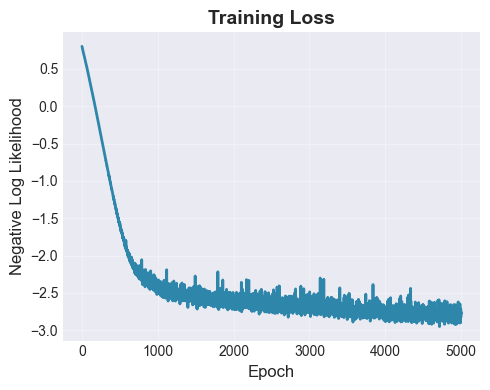

Final loss: -2.7785


In [48]:
plt.figure(figsize=(5, 4))

plt.subplot()
plt.plot(losses, linewidth=2, color='#2E86AB')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Negative Log Likelihood', fontsize=12)
plt.title('Training Loss', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final loss: {losses[-1]:.4f}")

### Make Predictions

In [49]:
# Predict on test set
mean_pred, std_pred = predict(dkl_model, X_test, return_std=True)

print(f"Predictions shape: {mean_pred.shape}")
print(f"Uncertainty shape: {std_pred.shape}")
print(f"Mean uncertainty: {std_pred.mean():.4f}")

Predictions shape: (50,)
Uncertainty shape: (50,)
Mean uncertainty: 0.2699


### Evaluate Performance

In [50]:
# Compute metrics
metrics = compute_metrics(y_test, mean_pred, std_pred)
print_metrics(metrics, "Test Set Performance")


               Test Set Performance               
  MSE       :     0.080532
  RMSE      :     0.283782
  MAE       :     0.235628
  R2        :    -0.200885
  NLL       :     0.164320
  MSLL      :     0.164320



### Visualize Predictions

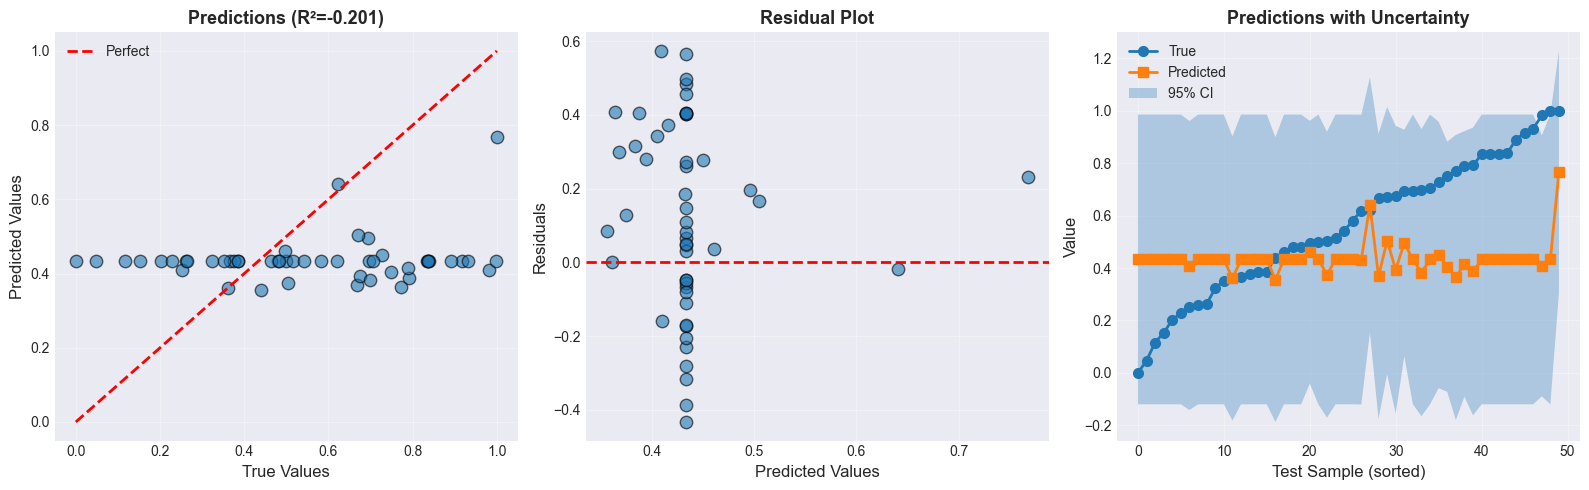

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Predictions vs True
axes[0].scatter(y_test, mean_pred, alpha=0.6, s=80, edgecolors='k', linewidth=1)
min_val = min(y_test.min(), mean_pred.min())
max_val = max(y_test.max(), mean_pred.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect')
axes[0].set_xlabel('True Values', fontsize=12)
axes[0].set_ylabel('Predicted Values', fontsize=12)
axes[0].set_title(f'Predictions (R²={metrics["r2"]:.3f})', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Residuals
residuals = y_test - mean_pred
axes[1].scatter(mean_pred, residuals, alpha=0.6, s=80, edgecolors='k', linewidth=1)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Values', fontsize=12)
axes[1].set_ylabel('Residuals', fontsize=12)
axes[1].set_title('Residual Plot', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# 3. Predictions with uncertainty
sorted_idx = np.argsort(y_test)
x_axis = np.arange(len(y_test))

axes[2].plot(x_axis, y_test[sorted_idx], 'o-', label='True', linewidth=2, markersize=7)
axes[2].plot(x_axis, mean_pred[sorted_idx], 's-', label='Predicted', linewidth=2, markersize=7)
axes[2].fill_between(
    x_axis,
    mean_pred[sorted_idx] - 2*std_pred[sorted_idx],
    mean_pred[sorted_idx] + 2*std_pred[sorted_idx],
    alpha=0.3,
    label='95% CI'
)
axes[2].set_xlabel('Test Sample (sorted)', fontsize=12)
axes[2].set_ylabel('Value', fontsize=12)
axes[2].set_title('Predictions with Uncertainty', fontsize=13, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## Uncertainty Quantification

Deep Kernel GP provides two types of uncertainty:
- **Epistemic**: Model uncertainty (reducible with more data)
- **Aleatoric**: Observation noise (irreducible)

In [62]:
# Decompose uncertainty
mean_unc, epistemic, aleatoric, total = predict_with_epistemic_aleatoric(
    dkl_model, X_test
)

# Convert to std (from variance)
epistemic_std = np.sqrt(epistemic)
aleatoric_std = np.sqrt(aleatoric)
total_std = np.sqrt(total)

print("Uncertainty Decomposition:")
print(f"  Epistemic (model):      {epistemic_std.mean():.4f} ± {epistemic_std.std():.4f}")
print(f"  Aleatoric (noise):      {aleatoric_std.mean():.4f} ± {aleatoric_std.std():.4f}")
print(f"  Total:                  {total_std.mean():.4f} ± {total_std.std():.4f}")
print(f"  Epistemic/Aleatoric:    {epistemic_std.mean()/aleatoric_std.mean():.2f}")

Uncertainty Decomposition:
  Epistemic (model):      0.2697 ± 0.0135
  Aleatoric (noise):      0.0108 ± 0.0000
  Total:                  0.2699 ± 0.0135
  Epistemic/Aleatoric:    24.91


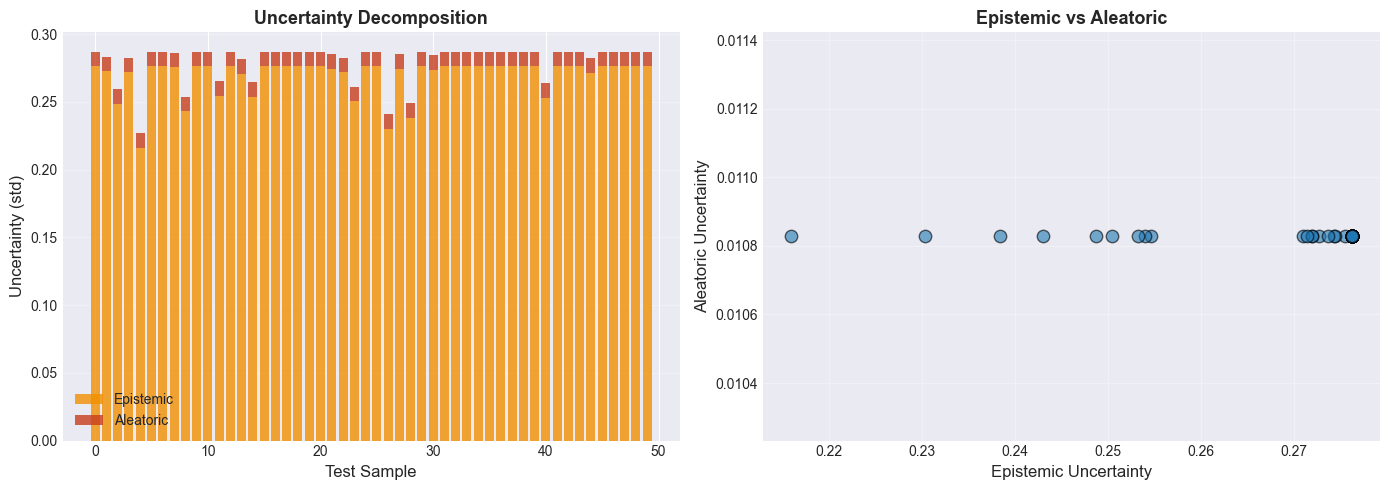

In [63]:
# Visualize uncertainty decomposition
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Stacked bar chart
x_axis = np.arange(len(y_test))
axes[0].bar(x_axis, epistemic_std, label='Epistemic', alpha=0.8, color='#F18F01')
axes[0].bar(x_axis, aleatoric_std, bottom=epistemic_std, label='Aleatoric', alpha=0.8, color='#C73E1D')
axes[0].set_xlabel('Test Sample', fontsize=12)
axes[0].set_ylabel('Uncertainty (std)', fontsize=12)
axes[0].set_title('Uncertainty Decomposition', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Scatter plot
axes[1].scatter(epistemic_std, aleatoric_std, alpha=0.6, s=80, edgecolors='k', linewidth=1)
axes[1].set_xlabel('Epistemic Uncertainty', fontsize=12)
axes[1].set_ylabel('Aleatoric Uncertainty', fontsize=12)
axes[1].set_title('Epistemic vs Aleatoric', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Calibration Analysis

Check if our uncertainty estimates are well-calibrated.

In [54]:
# Compute calibration
calibration = compute_calibration(y_test, mean_pred, std_pred, n_bins=10)

print(f"Mean Absolute Calibration Error: {calibration['mace']:.4f}")
print("(Lower is better, 0 = perfect calibration)")

Mean Absolute Calibration Error: 0.0567
(Lower is better, 0 = perfect calibration)


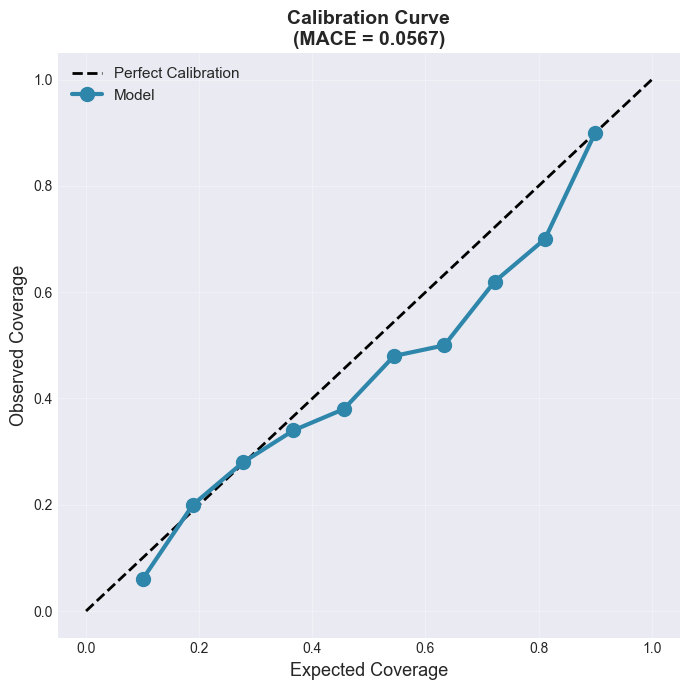

In [55]:
# Plot calibration curve
plt.figure(figsize=(7, 7))

conf = calibration['confidence_levels']
obs = calibration['observed_coverage']

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect Calibration')
plt.plot(conf, obs, 'o-', linewidth=3, markersize=10, color='#2E86AB', label='Model')

plt.xlabel('Expected Coverage', fontsize=13)
plt.ylabel('Observed Coverage', fontsize=13)
plt.title(f'Calibration Curve\n(MACE = {calibration["mace"]:.4f})', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## Confidence Weighting

Sometimes data points have different reliability. We can weight them accordingly.

### Generate Data with Varying Noise

In [56]:
# Generate data with heteroscedastic noise
n_train = 150
X_noisy = np.random.randn(n_train, 50)

# True function
y_true = X_noisy[:, 0] + 2*X_noisy[:, 1] + np.sin(X_noisy[:, 2])

# Noise level varies with input
noise_level = 0.1 + 0.5 * np.abs(X_noisy[:, 0])  # Higher noise for larger |x[0]|
y_noisy = y_true + noise_level * np.random.randn(n_train)

print(f"Noise level range: [{noise_level.min():.3f}, {noise_level.max():.3f}]")

Noise level range: [0.102, 1.831]


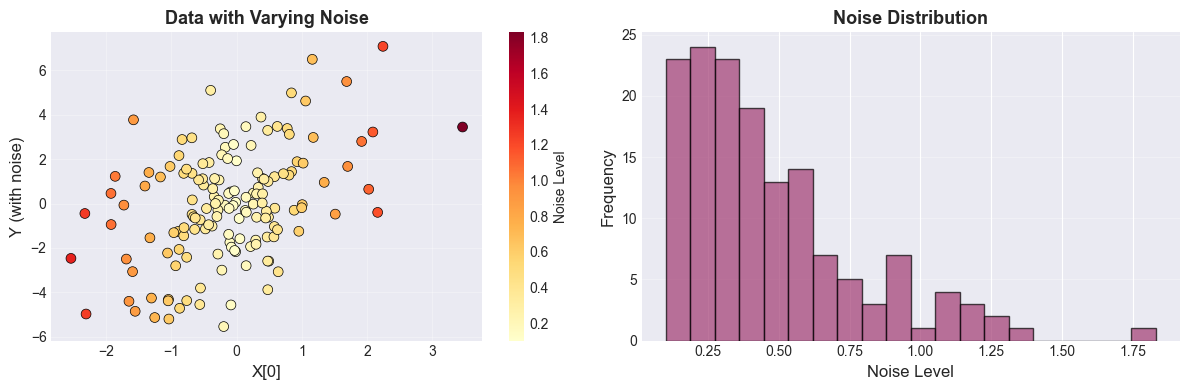

In [57]:
# Visualize noise distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(X_noisy[:, 0], y_noisy, c=noise_level, s=50, cmap='YlOrRd', edgecolors='k', linewidth=0.5)
plt.colorbar(label='Noise Level')
plt.xlabel('X[0]', fontsize=12)
plt.ylabel('Y (with noise)', fontsize=12)
plt.title('Data with Varying Noise', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(noise_level, bins=20, edgecolor='k', alpha=0.7, color='#A23B72')
plt.xlabel('Noise Level', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Noise Distribution', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Train with Confidence Weights

In [58]:
# Compute confidence weights (inverse of noise level)
# Lower noise -> Higher confidence
confidence = 1.0 / (1.0 + noise_level**2)

print(f"Confidence range: [{confidence.min():.3f}, {confidence.max():.3f}]")
print(f"High noise -> Low confidence: {confidence[noise_level > 0.4].mean():.3f}")
print(f"Low noise -> High confidence: {confidence[noise_level < 0.2].mean():.3f}")

Confidence range: [0.230, 0.990]
High noise -> Low confidence: 0.675
Low noise -> High confidence: 0.977


In [59]:
# Train WITHOUT confidence weights
print("Training WITHOUT confidence weighting...")
_, _, model_no_weight, _ = fit_dkgp(
    X_noisy, y_noisy,
    feature_dim=16,
    num_epochs=800,
    verbose=False
)

# Train WITH confidence weights
print("Training WITH confidence weighting...")
_, _, model_weighted, _ = fit_dkgp(
    X_noisy, y_noisy,
    confidence_weights=confidence,
    feature_dim=16,
    num_epochs=800,
    verbose=False
)

Training WITHOUT confidence weighting...
Training WITH confidence weighting...
✅ Both models trained!


### Compare Performance

In [60]:
# Generate clean test data
X_test_clean = np.random.randn(50, 50)
y_test_clean = X_test_clean[:, 0] + 2*X_test_clean[:, 1] + np.sin(X_test_clean[:, 2])

# Predictions
pred_no_weight, _ = predict(model_no_weight, X_test_clean)
pred_weighted, _ = predict(model_weighted, X_test_clean)

# Compute errors
mse_no_weight = np.mean((y_test_clean - pred_no_weight)**2)
mse_weighted = np.mean((y_test_clean - pred_weighted)**2)

print("Test Set Performance:")
print(f"  Without weighting: MSE = {mse_no_weight:.4f}")
print(f"  With weighting:    MSE = {mse_weighted:.4f}")
print(f"  Improvement:       {(1 - mse_weighted/mse_no_weight)*100:.1f}%")

Test Set Performance:
  Without weighting: MSE = 4.7490
  With weighting:    MSE = 4.8267
  Improvement:       -1.6%


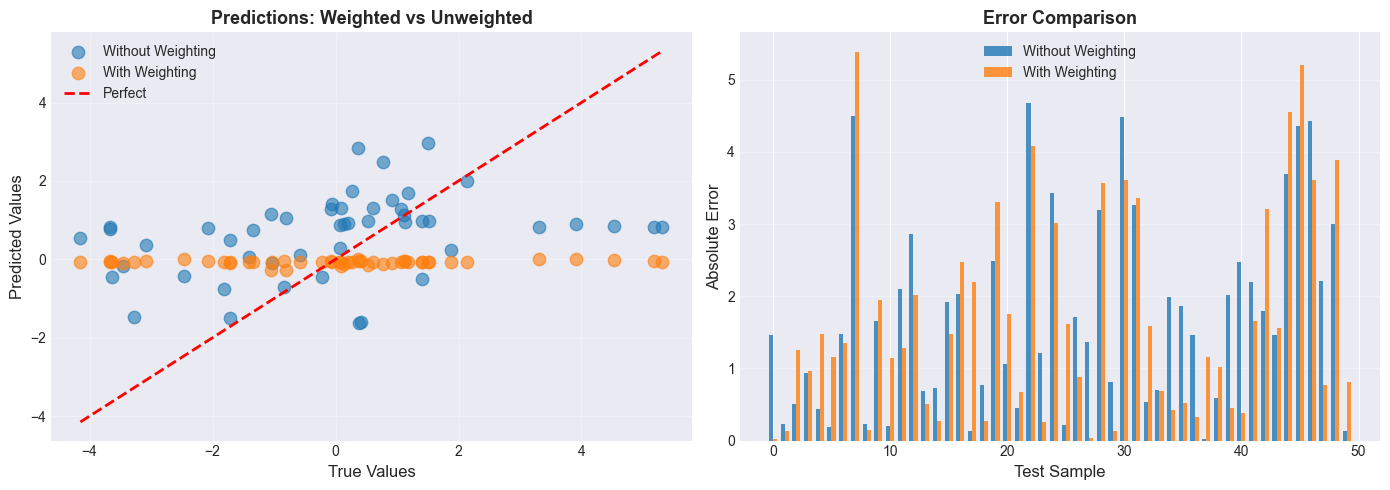

In [61]:
# Visualize comparison
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test_clean, pred_no_weight, alpha=0.6, s=80, label='Without Weighting')
plt.scatter(y_test_clean, pred_weighted, alpha=0.6, s=80, label='With Weighting')
min_val = y_test_clean.min()
max_val = y_test_clean.max()
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect')
plt.xlabel('True Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.title('Predictions: Weighted vs Unweighted', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
errors_no_weight = np.abs(y_test_clean - pred_no_weight)
errors_weighted = np.abs(y_test_clean - pred_weighted)
x = np.arange(len(y_test_clean))
width = 0.35
plt.bar(x - width/2, errors_no_weight, width, label='Without Weighting', alpha=0.8)
plt.bar(x + width/2, errors_weighted, width, label='With Weighting', alpha=0.8)
plt.xlabel('Test Sample', fontsize=12)
plt.ylabel('Absolute Error', fontsize=12)
plt.title('Error Comparison', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

---
## Bayesian Optimization

Use Deep Kernel GP to optimize an expensive black-box function.

### Define Test Function

In [42]:
def branin_high_dim(x):
    """
    Branin function (classic optimization benchmark) in high dimensions.
    Only first 2 dimensions matter, rest are noise.
    Global minimum ≈ 0.398 at (π, 2.275) and two other locations.
    """
    x1 = x[0] * 15 - 5   # Scale to [-5, 10]
    x2 = x[1] * 15        # Scale to [0, 15]
    
    a = 1
    b = 5.1 / (4 * np.pi**2)
    c = 5 / np.pi
    r = 6
    s = 10
    t = 1 / (8 * np.pi)
    
    term1 = a * (x2 - b * x1**2 + c * x1 - r)**2
    term2 = s * (1 - t) * np.cos(x1)
    term3 = s
    
    # Add small noise from other dimensions
    if len(x) > 2:
        noise = 0.05 * np.sum(x[2:]**2)
    else:
        noise = 0
    
    return term1 + term2 + term3 + noise

print(f"True global minimum: ≈ 0.398")
print(f"Test evaluation: {branin_high_dim(np.array([0.5424, 0.1517] + [0]*18)):.4f}")

True global minimum: ≈ 0.398
Test evaluation: 0.3981


### Initialize with Random Samples

In [43]:
# Problem setup
input_dim = 20
n_initial = 10
n_iterations = 15

# Generate candidate pool
n_candidates = 2000
candidates = np.random.uniform(0, 1, size=(n_candidates, input_dim))

# Initial random samples
initial_idx = np.random.choice(n_candidates, n_initial, replace=False)
X_observed = candidates[initial_idx]
y_observed = np.array([branin_high_dim(x) for x in X_observed])

print(f"Initial samples: {n_initial}")
print(f"Initial best: {y_observed.min():.4f}")
print(f"Candidate pool: {n_candidates} points")

Initial samples: 10
Initial best: 10.3308
Candidate pool: 2000 points


### Run Bayesian Optimization Loop

In [44]:
# Track progress
best_values = [y_observed.min()]
all_values = list(y_observed)
ei_values_history = []

print("Starting Bayesian Optimization...\n")
print(f"{'Iter':<6} {'Next f(x)':<12} {'Best f(x)':<12} {'Max EI':<12}")
print("="*48)

for iteration in range(n_iterations):
    # Train model on current observations
    _, _, model, _ = fit_dkgp(
        X_observed,
        y_observed,
        feature_dim=16,
        num_epochs=500,
        verbose=False
    )
    
    # Get current best
    best_f = y_observed.min()
    
    # Remove already evaluated candidates
    mask = np.ones(len(candidates), dtype=bool)
    for x in X_observed:
        mask &= ~np.all(np.isclose(candidates, x), axis=1)
    available = candidates[mask]
    
    # Compute Expected Improvement
    ei = expected_improvement(
        model,
        available,
        best_f=best_f,
        xi=0.01,
        maximize=False  # Minimize Branin
    )
    
    # Select next point
    next_idx = np.argmax(ei)
    next_point = available[next_idx]
    next_value = branin_high_dim(next_point)
    
    # Update observations
    X_observed = np.vstack([X_observed, next_point])
    y_observed = np.append(y_observed, next_value)
    
    # Track progress
    best_values.append(y_observed.min())
    all_values.append(next_value)
    ei_values_history.append(ei.max())
    
    print(f"{iteration+1:<6} {next_value:<12.4f} {y_observed.min():<12.4f} {ei.max():<12.6f}")

print("="*48)
print(f"\nOptimization complete!")
print(f"Final best value: {y_observed.min():.4f}")
print(f"True global minimum: 0.398")
print(f"Gap: {y_observed.min() - 0.398:.4f}")

Starting Bayesian Optimization...

Iter   Next f(x)    Best f(x)    Max EI      
1      16.5887      10.3308      3.942619    
2      12.3176      10.3308      4.598991    
3      17.0432      10.3308      4.701797    
4      5.1099       5.1099       3.777411    
5      65.0935      5.1099       0.693895    
6      16.7681      5.1099       1.080163    
7      100.5611     5.1099       0.501166    
8      40.5424      5.1099       1.212326    
9      2.6644       2.6644       0.574096    
10     71.7088      2.6644       0.076593    
11     118.3466     2.6644       0.176489    
12     9.1303       2.6644       0.070918    
13     42.3977      2.6644       0.201966    
14     1.2928       1.2928       0.179974    
15     15.1570      1.2928       0.013095    

Optimization complete!
Final best value: 1.2928
True global minimum: 0.398
Gap: 0.8948


### Visualize Optimization Progress

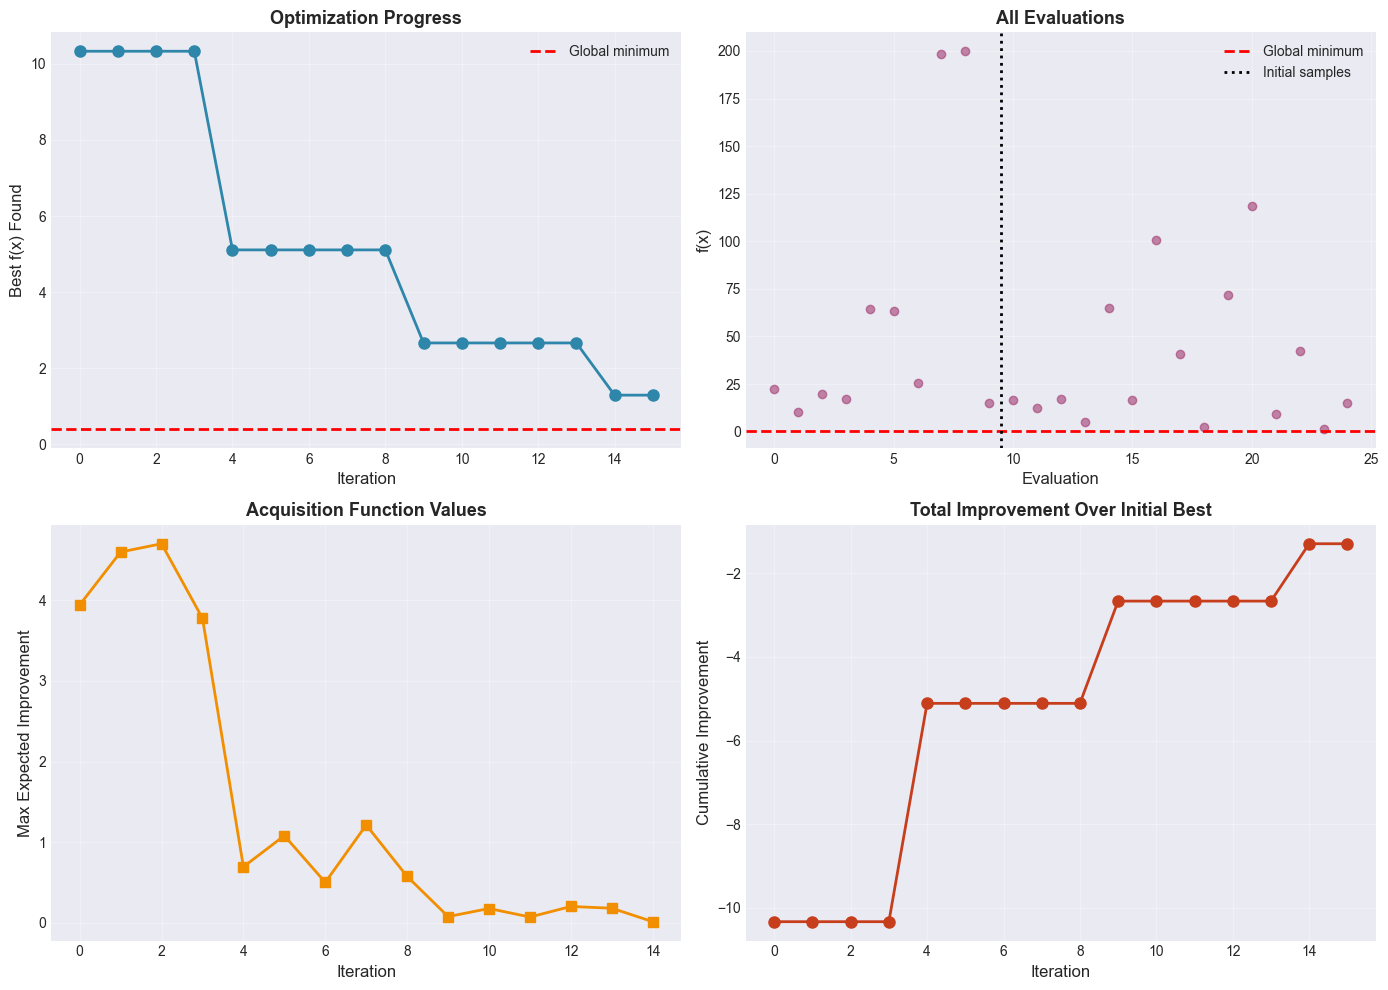

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Best value over iterations
axes[0, 0].plot(best_values, 'o-', linewidth=2, markersize=8, color='#2E86AB')
axes[0, 0].axhline(y=0.398, color='r', linestyle='--', linewidth=2, label='Global minimum')
axes[0, 0].set_xlabel('Iteration', fontsize=12)
axes[0, 0].set_ylabel('Best f(x) Found', fontsize=12)
axes[0, 0].set_title('Optimization Progress', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. All evaluations
axes[0, 1].plot(all_values, 'o', alpha=0.6, markersize=6, color='#A23B72')
axes[0, 1].axhline(y=0.398, color='r', linestyle='--', linewidth=2, label='Global minimum')
axes[0, 1].axvline(x=n_initial-0.5, color='k', linestyle=':', linewidth=2, label='Initial samples')
axes[0, 1].set_xlabel('Evaluation', fontsize=12)
axes[0, 1].set_ylabel('f(x)', fontsize=12)
axes[0, 1].set_title('All Evaluations', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Expected Improvement over iterations
axes[1, 0].plot(ei_values_history, 's-', linewidth=2, markersize=7, color='#F18F01')
axes[1, 0].set_xlabel('Iteration', fontsize=12)
axes[1, 0].set_ylabel('Max Expected Improvement', fontsize=12)
axes[1, 0].set_title('Acquisition Function Values', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Cumulative improvement
improvements = np.maximum.accumulate(-np.array(best_values))  # Negative for minimization
axes[1, 1].plot(improvements, 'o-', linewidth=2, markersize=8, color='#C73E1D')
axes[1, 1].set_xlabel('Iteration', fontsize=12)
axes[1, 1].set_ylabel('Cumulative Improvement', fontsize=12)
axes[1, 1].set_title('Total Improvement Over Initial Best', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Compare Acquisition Functions

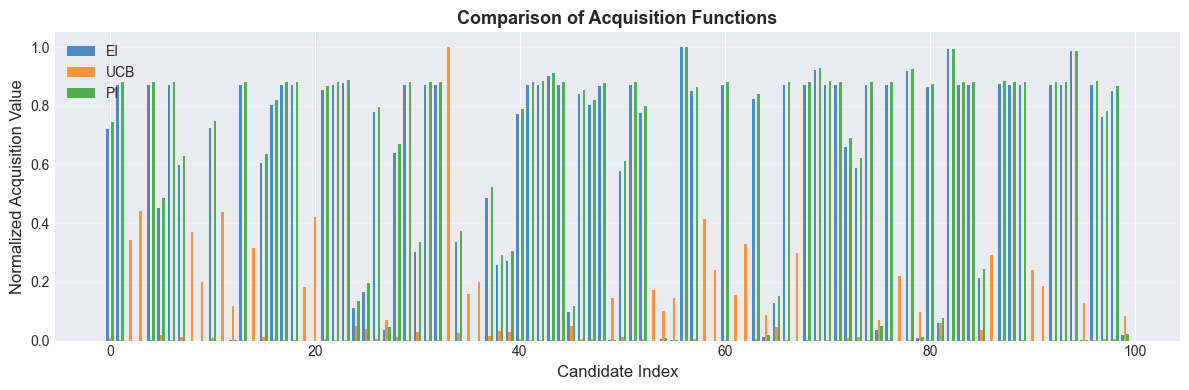


Top 3 candidates by acquisition function:
  EI:  indices [56 82 94]
  UCB: indices [56 82 94]
  PI:  indices [56 82 94]


In [46]:
# Train final model
_, _, final_model, _ = fit_dkgp(
    X_observed, y_observed,
    feature_dim=16,
    num_epochs=500,
    verbose=False
)

# Sample some test candidates
test_candidates = np.random.uniform(0, 1, (100, input_dim))
best_f = y_observed.min()

# Compute different acquisition functions
ei = expected_improvement(final_model, test_candidates, best_f, maximize=False)
ucb = upper_confidence_bound(final_model, test_candidates, beta=2.0, maximize=False)
pi = probability_of_improvement(final_model, test_candidates, best_f, maximize=False)

# Normalize for comparison
ei_norm = (ei - ei.min()) / (ei.max() - ei.min() + 1e-8)
ucb_norm = (ucb - ucb.min()) / (ucb.max() - ucb.min() + 1e-8)
pi_norm = (pi - pi.min()) / (pi.max() - pi.min() + 1e-8)

# Plot
plt.figure(figsize=(12, 4))

x = np.arange(len(test_candidates))
width = 0.25

plt.bar(x - width, ei_norm, width, label='EI', alpha=0.8)
plt.bar(x, ucb_norm, width, label='UCB', alpha=0.8)
plt.bar(x + width, pi_norm, width, label='PI', alpha=0.8)

plt.xlabel('Candidate Index', fontsize=12)
plt.ylabel('Normalized Acquisition Value', fontsize=12)
plt.title('Comparison of Acquisition Functions', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Show top candidates for each
print("\nTop 3 candidates by acquisition function:")
print(f"  EI:  indices {np.argsort(ei)[-3:][::-1]}")
print(f"  UCB: indices {np.argsort(ucb)[:3]}")
print(f"  PI:  indices {np.argsort(pi)[-3:][::-1]}")